# Sixth Exercise (HPO)

This exercise focuses on hyperparameter optimization with neural networks.

We will
- define hyperparameter-configuration search-spaces
- train deep learning models with various hyper parameters
- use random search as a basic hyperparameter optimizer
- use BOHB as an advanced hyperparameter optimizer

It's in the nature of hyperparameter optimization, that you'll have to train a lot of models. 
Therefore execution time will be longer in this exercise, running the completed notebook takes about 30 minutes on a tutor's 3 year old laptop.

#### Install HpBandster and torchvision

You need to install two more python packages for this exercise.

- [torchvision](https://pytorch.org/docs/stable/torchvision/) provides utility methods for pytorch.
- [HpBandSter](https://github.com/automl/HpBandSter) is a fast, parallel implementation of several hyperparameter optimizers.  
   We can define even complex hyperparameter search spaces with [ConfigSpace](https://github.com/automl/ConfigSpace), which comes along HpBandSter as dependency.


Install with anaconda/conda
```
conda install torchvision
conda install hpbandster
```

or with plain python
```
pip3 install torchvision
pip3 install hpbandster
```

In [2]:
!pip3 install torchvision
!pip3 install hpbandster

    100% |████████████████████████████████| 61kB 2.2MB/s 
    100% |████████████████████████████████| 519.5MB 29kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x58630000 @  0x7f850e65d2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 2.0MB 4.9MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 61kB 2.2MB/s 
    100% |████████████████████████████████| 92kB 4.1MB/s 
    100% |████████████████████████████████| 921kB 6.3MB/s 
    100% |████████████████████████████████| 2.1MB 7.7MB/s 
  Running setup.py bdist_wheel for hpbandster ... - \ done
  Stored in directory: /root/.cache/pip/wheels/9d/57/62/6b00c8011b

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
import os
from typing import Tuple, List

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import ConfigSpace as CS
import ConfigSpace.hyperparameters as CSH
from ConfigSpace.conditions import NotEqualsCondition


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


def load_mnist_minibatched(batch_size: int, n_train: int = 8192, n_valid: int = 1024,
                           valid_test_batch_size: int = 1024) -> Tuple[DataLoader, DataLoader, DataLoader]:
    train_dataset = torchvision.datasets.MNIST(
        root='../data', train=True, transform=transforms.ToTensor(), download=True)
    test_dataset = torchvision.datasets.MNIST(
        root='../data', train=False, transform=transforms.ToTensor())

    train_sampler = SubsetRandomSampler(range(n_train))
    validation_sampler = SubsetRandomSampler(range(n_train, n_train+n_valid))

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, sampler=train_sampler)
    validation_loader = DataLoader(dataset=train_dataset, batch_size=valid_test_batch_size,
                                   sampler=validation_sampler)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=valid_test_batch_size, 
                                              shuffle=False)
    return train_loader, validation_loader, test_loader


def evaluate_accuracy(model: nn.Module, data_loader: DataLoader) -> float:
    model.eval()
    correct = 0
    with torch.no_grad():
        for x, y in data_loader:
            output = model(x)
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(y.view_as(pred)).sum().item()
    accuracy = correct / len(data_loader.sampler)
    return(accuracy)

## Random Search

Here we get hands on hyperparameter optimization using random search.

### Model and Hyperparameter Space

First we define a configurable model and a hyperparameter space. You learn how to use *ConfigSpace* to define the hyperparameters, by looking at [this example](https://automl.github.io/SMAC3/stable/quickstart.html#using-smac-in-python-svm).   

**Task:** Complete the functions as described in the docstrings.

**Hint:** The `CS.GreaterThanCondition(conditioned_hyperparameter, lefthand_side, righthand_side)` method might be useful.

In [0]:
from collections import OrderedDict

class Flatten(nn.Module):
  def forward(self, input):
    self.input_shape = input.shape
    return input.view(input.size(0), -1)
    
def get_conv_model(num_filters_per_layer: List[int]) -> nn.Module:
    """Builds a deep convolutional model with various number of convolution
       layers for MNIST input using pytorch.
    
    for each element in num_filters_per_layer:
        convolution (conv_kernel_size, num_filters, stride=1, padding=0)
        relu
        max pool    (pool_kernel_size, stride=1)
    linear
    log softmax
    """
    assert len(num_filters_per_layer) > 0, "len(num_filters_per_layer) should be greater than 0"
    pool_kernel_size = 2
    conv_kernel_size = 3
    #print(len(num_filters_per_layer))
    # START TODO ################
    img_size = 28
    layers = []
    old_num_filters = 1
    for  num_filters in num_filters_per_layer:
      layers += [nn.Conv2d(old_num_filters, num_filters,conv_kernel_size, stride=1, padding=0)]
      layers += [nn.ReLU(True)]
      layers += [nn.MaxPool2d(pool_kernel_size, stride=1)]
      img_size = (img_size - conv_kernel_size + 1 ) - pool_kernel_size + 1
      old_num_filters = num_filters
      #print(f"img_size = {img_size}")
    layers += [Flatten()]
    layers += [nn.Linear(old_num_filters*img_size*img_size, 10)]
    layers += [nn.LogSoftmax(dim=1)]
    return nn.Sequential(*layers)
    # End TODO ################


def get_configspace() -> CS.ConfigurationSpace:
    """ Define a conditional hyperparameter search-space.
    
    hyperparameters:
      lr              from 1e-6 to 1e-0 (log, float)
      num_filters_1   from    2 to    8 (int)
      num_filters_2   from    2 to    8 (int)
      num_conv_layers from    1 to    2 (int)
    
    conditions: 
      include num_filters_2 only if num_conv_layers > 1
    """
    cs = CS.ConfigurationSpace()
    # START TODO ################
    
    hyper_list = []
    hyper_list.append(CSH.UniformFloatHyperparameter(name = 'lr', lower = 1e-6, upper = 1,log=True))
    hyper_list.append(CSH.UniformIntegerHyperparameter(name = 'num_filters_1', lower = 2, upper = 8))
    
    num_filters_2 = CSH.UniformIntegerHyperparameter(name = 'num_filters_2', lower = 2, upper = 8)
    hyper_list.append(num_filters_2) 
    
    num_conv_layers = CSH.UniformIntegerHyperparameter(name = 'num_conv_layers', lower = 1, upper = 2)
    hyper_list.append(num_conv_layers)
    
    cs.add_hyperparameters(hyper_list)
    
    use_2 = NotEqualsCondition(child=num_filters_2, parent=num_conv_layers, value=1)
    cs.add_conditions([use_2])
    
    # End TODO ################
    return cs

In [0]:
cs = get_configspace()

### Run model with configuration

A single sample from your hyperparameter space is a *Configuration*. You can use the configuration similar to a dictionary, it supports *config.keys(), config.values(), value = config[key], key in config, …* .
You can iterate a *DataLoader* to access (data, label) batches.

**Note:** If a condition isn't met, the conditional hyperparameter isn't included in the configuration.

**Task:** Complete the function to run a model like defined by the configuration. The function should return the model and the *validation error* for each epoch. You can use *evaluate_accuracy* (defined above), don't forget to switch between train and eval mode.

In [0]:
def run_conv_model(config: CS.Configuration, epochs: int, train_loader: DataLoader,
                   validation_loader: DataLoader) -> Tuple[nn.Module, List[float]]:    
    """ Run and evaluate a model from get_conv_model with NLLLoss and SGD.
    """
    # START TODO ################
    # retrieve the number of filters from the config and create the model
    model = get_conv_model([config['num_filters_1'], config['num_filters_2']] 
                            if ('num_filters_2') in config else [config['num_filters_1']] )  
    # define loss and optimizer
    #loss_fn = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr = config['lr'])
    
    # train the model for `epochs` and save the validation error for each epoch in
    val_errors = []
    for epoch in range(1, epochs + 1):
      model.train()
      for batch_idx, (data, target) in enumerate(train_loader):
         
          optimizer.zero_grad()
          output = model(data)
          #print(output.shape)
          #print(target.shape)
          loss = F.nll_loss(output, target)
          loss.backward()
          optimizer.step()
          if batch_idx % 10 == 0:
              print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  epoch, batch_idx * len(data), len(train_loader.dataset),
                  100. * batch_idx / len(train_loader), loss.item()))
      val_errors.append(evaluate_accuracy(model,validation_loader))
    # End TODO ################
    return model, val_errors

Now let's run models with various, random hyperparameter configurations. Don't forget to store all the configuration and validation errors for further evaluation.

**Tipp:** *ConfigSpace* objects have a *.sample_configuration()* function to sample a random configuration.

**Task:** Run *n_random_samples* models for *n_epochs* and store the tuple `(model, config, val_errors)` in `results`.

In [8]:
n_random_samples = 18
n_epochs = 9
cs = get_configspace()
train_loader, validation_loader, _ = load_mnist_minibatched(batch_size=32, n_train=4096, n_valid=512)

# START TODO ################
results = []
for i in range(n_random_samples):
  print(f"Configuration Sample: {i}/{n_random_samples}")
  config = cs.sample_configuration()
  print(config)
  #for epoch in range(1, n_epochs + 1):
  #    models, val_errors = run_conv_model(config, epoch, train_loader, validation_loader)
  model, val_errors = run_conv_model(config, n_epochs, train_loader, validation_loader) 
  results.append((model, config, val_errors))  
# End TODO ################

Processing...
Done!
Configuration Sample: 0/18
Configuration:
  lr, Value: 0.00014246674013680232
  num_conv_layers, Value: 2
  num_filters_1, Value: 3
  num_filters_2, Value: 7

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.320747
Train Epoch: 1 [320/60000 (8%)]	Loss: 2.333996
Train Epoch: 1 [640/60000 (16%)]	Loss: 2.318193
Train Epoch: 1 [960/60000 (23%)]	Loss: 2.306520
Train Epoch: 1 [1280/60000 (31%)]	Loss: 2.297177
Train Epoch: 1 [1600/60000 (39%)]	Loss: 2.332345
Train Epoch: 1 [1920/60000 (47%)]	Loss: 2.315163
Train Epoch: 1 [2240/60000 (55%)]	Loss: 2.299136
Train Epoch: 1 [2560/60000 (62%)]	Loss: 2.324717
Train Epoch: 1 [2880/60000 (70%)]	Loss: 2.320172
Train Epoch: 1 [3200/60000 (78%)]	Loss: 2.330994
Train Epoch: 1 [3520/60000 (86%)]	Loss: 2.319759
Train Epoch: 1 [3840/60000 (94%)]	Loss: 2.297582
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.320140
Train Epoch: 2 [320/60000 (8%)]	Loss: 2.322342
Train Epoch: 2 [640/60000 (16%)]	Loss: 2.315386
Train Epoch: 2 [960/60000 (23%)]	Loss: 2.314440
Trai

### Evaluate 

Now we should evaluate the previous runs. Evaluation in hyperparameter optimization can mean two different things: On the one hand, we might be only interested in the model with the best performance. On the other hand, we might want to find the best hyperparameter configuration to then train a model with these hyper-parameters (but with e.g. more epochs).

**Task:** Print the model and final validation error of the best model in `results`.

In [9]:
# START TODO ################

val_acc = [results[best_model_idx][-1][-1] for best_model_idx in range(len(results))]
max_val_acc = max(val_acc)
idx = val_acc.index(max_val_acc)
print(f"Maximum Validation Accuracy = {max_val_acc}")
print(results[idx][1])
results[idx][1]["lr"]
# END TODO ################

Maximum Validation Accuracy = 0.9453125
Configuration:
  lr, Value: 0.03633768066215828
  num_conv_layers, Value: 2
  num_filters_1, Value: 2
  num_filters_2, Value: 6



0.03633768066215828

Let's further investigate which hyperparameters work well and which don't.

**Task:** Print a scatter plot of learning rate (x) and number of filters (sum over layers, y). Scale the size of the scatter points by the error in the last epoch (10 to 100).

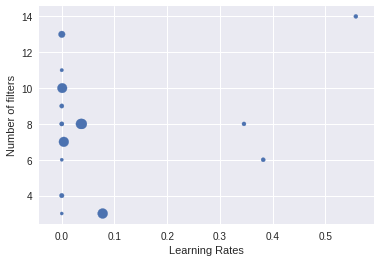

In [14]:
# START TODO ################
val_acc = [results[best_model_idx][-1][-1] for best_model_idx in range(len(results))]
lrs =  [results[best_model_idx][1]["lr"] for best_model_idx in range(len(results))]

num_filters = [[results[best_model_idx][1]['num_filters_1'] + results[best_model_idx][1]['num_filters_2']] if ('num_filters_2') in results[best_model_idx][1] else [results[best_model_idx][1]['num_filters_1']] for best_model_idx in range(len(results))]
#print(len(lrs))
#print(len(num_filters))
#Scale the values from 10 to 100
scaled = [((100-10)/(max(val_acc) -min(val_acc)))*(v - max(val_acc)) + 100 for v in val_acc]
#print(scaled)
plt.scatter(lrs, num_filters, s=scaled)
plt.xlabel('Learning Rates')
plt.ylabel('Number of filters')  
plt.show()
# END TODO ################

**Question:** What pattern do you see? Why might it occur?

**Answer:**  We see that large and very low learning rates show poor performance. It happens as the gradient decend algorithm cannot converge for very low learning rates and jumps between the values and missed the minimum point for large learning rates. We also see that number of filters have a lower significance on the result compared with the learning rate.

After looking at the final error, let's now have a look at the training error.

**Task:** Plot error curves (error per epoch) for all your configurations in one figure.

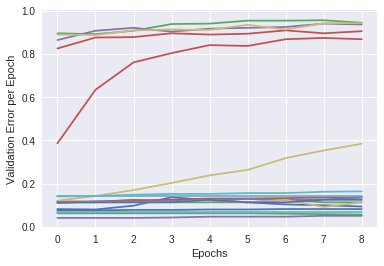

In [15]:
# START TODO ################
#val_errors_p_ep = [results[best_model_idx][-1][:] for best_model_idx in range(len(results))]
for model_idx in range(len(results)):
  plt.plot(results[model_idx][-1][:])

plt.ylabel('Validation Error per Epoch')
plt.xlabel('Epochs')  
plt.show()


# END TODO ################

**Questions:** How could you detect configurations with a low error earlier/faster? Why could this be problematic? 

**Answers:** The configurations with lower accuracies can be stopped on earlier epochs. On one hand, it decreases the computational loss since we wouldnt evaluate the models which do not improve at all, but on the other hand, it also stops some models that started with low accuracy but can converge to the best accuracy value, later. Therefore, this technique does not guarantee finding the optimal solution.

### Your Feedback on Exercise 6.1

Wonderful exercise, optimization was always a problem when developing deep learning codes. I personally, didn't know that we could use these environments to check the values efficiently. It took more than 10 hours to solve this exercise.

## BOHB

Here we will use the more advanced hyperparameter optimizer [BOHB](https://www.automl.org/blog_bohb/) (Bayesian Optimization with Hyperband).
Based on [Hyperband](https://arxiv.org/pdf/1603.06560.pdf), BOHB evaluates configurations on your model with increasing budgets. In the context of Deep Learning, budget can be the number of epochs or the number of training samples. In lower budget evaluations, BOHB can look at more configurations. Full budget evaluations avoid missing configurations which are poor at the beginnning but good at the end (and vice versa). 
At the start of a run, BOHB samples configurations randomly. After some time, BOHB then uses a bayesian model (based on Parzen Tree Estimators), sampling only promising configs.

This exercise part is based on the [HpBandSter Examples](https://automl.github.io/HpBandSter/build/html/auto_examples/index.html) and the [HpBandSter Documentation](https://automl.github.io/HpBandSter/). *HpBandSter* provides a fast implementation of *Randomsearch*, *Hyperband* and *BOHB*. The optimization can easily be distributed between multiple cores or even multiple computers.

In [16]:
import pickle
import logging

from hpbandster.core.worker import Worker
import hpbandster.core.nameserver as hpns
import hpbandster.core.result as hpres
from hpbandster.optimizers import BOHB

logging.getLogger('hpbandster').setLevel(logging.DEBUG)

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Implement Worker

The worker defines the hyperparameter problem which we try to optimize.
*compute(...)* should - for a given configuration and budget - return a loss which the hyperparameter optimizer tries to minimize. In our case, we can use the number of epochs as budget and the validation error as loss. 
As best practice, we define the configuration space also in the worker.

If you need help, you might get some inspiration from the [HpBandSter Pytorch Worker Example](https://automl.github.io/HpBandSter/build/html/auto_examples/example_5_pytorch_worker.html#sphx-glr-auto-examples-example-5-pytorch-worker-py).

**Task:** Complete the methods below.

In [0]:
class PyTorchWorker(Worker):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.train_loader, self.validation_loader, self.test_loader =\
            load_mnist_minibatched(batch_size=32, n_train=4096, n_valid=512)

    @staticmethod
    def get_model(config: CS.Configuration) -> nn.Module:
        """ Define a configurable convolution model.
            
        See description of get_conv_model above for more details on the model.
        """
        # START TODO ################
        pool_kernel_size = 2
        conv_kernel_size = 3
        #print(len(num_filters_per_layer))
        # START TODO ################
        str_flt = ['num_filters_1','num_filters_2','num_filters_3']
        num_filters_per_layer = [config[str_flt[index]] for index in  range(config['num_conv_layers'])]
        
        img_size = 28
        layers = []
        old_num_filters = 1
        for  num_filters in num_filters_per_layer:
          layers += [nn.Conv2d(old_num_filters, num_filters,conv_kernel_size, stride=1, padding=0)]
          layers += [nn.ReLU(True)]
          layers += [nn.MaxPool2d(pool_kernel_size, stride=1)]
          img_size = (img_size - conv_kernel_size + 1 ) - pool_kernel_size + 1
          old_num_filters = num_filters
          #print(f"img_size = {img_size}")
        layers += [Flatten()]
        layers += [nn.Linear(old_num_filters*img_size*img_size, 10)]
        layers += [nn.LogSoftmax(dim=1)]
        
        return nn.Sequential(*layers)
  
        # END TODO ################
        
    @staticmethod
    def get_configspace() -> CS.Configuration:
        """ Define a conditional hyperparameter search-space.
    
        hyperparameters:
          num_filters_1   from    4 to   32 (int)
          num_filters_2   from    4 to   32 (int)
          num_filters_3   from    4 to   32 (int)
          num_conv_layers from    1 to    3 (int)
          lr              from 1e-6 to 1e-1 (float, log)
          sgd_momentum    from 0.00 to 0.99 (float)
          optimizer            Adam or  SGD (categoric)
          
        conditions: 
          include num_filters_2 only if num_conv_layers > 1
          include num_filters_3 only if num_conv_layers > 2
          include sgd_momentum  only if       optimizer = SGD
        """
        # START TODO ################
        cs = CS.ConfigurationSpace()
        
        hyper_list = []
        hyper_list.append(CSH.UniformIntegerHyperparameter(name = 'num_filters_1', lower = 4, upper = 32))

        num_filters_2 = CSH.UniformIntegerHyperparameter(name = 'num_filters_2', lower = 4, upper = 32)
        hyper_list.append(num_filters_2) 

        num_filters_3 = CSH.UniformIntegerHyperparameter(name = 'num_filters_3', lower = 4, upper = 32)
        hyper_list.append(num_filters_3)
        
        num_conv_layers = CSH.UniformIntegerHyperparameter(name = 'num_conv_layers', lower = 1, upper = 3)
        hyper_list.append(num_conv_layers)
        
        hyper_list.append(CSH.UniformFloatHyperparameter(name = 'lr', lower = 1e-6, upper = 1,log=True))
        
        sgd_momentum = CSH.UniformFloatHyperparameter(name = 'sgd_momentum', lower = 0.00, upper = 0.99)
        hyper_list.append(sgd_momentum)
        
        optimizer = CSH.CategoricalHyperparameter('optimizer',['Adam', 'SGD']) #categoric
        hyper_list.append(optimizer)
        
        cs.add_hyperparameters(hyper_list)
        
        cond1 = CS.conditions.GreaterThanCondition(num_filters_2, num_conv_layers, 1)
        cond2 = CS.conditions.GreaterThanCondition(num_filters_3, num_conv_layers, 2)
        cond3 = CS.conditions.EqualsCondition(sgd_momentum, optimizer, 'SGD')
        
        cs.add_conditions([cond1, cond2, cond3])
        
        return cs
        # END TODO ################

    def compute(self, config: CS.Configuration, budget: float, working_directory: str,
                *args, **kwargs) -> float:
      """Evaluate a function with the given config and budget and return a loss.

      Bohb tries to minimize the returned loss.

      In our case the function is the training and validation of a model,
      the budget is the number of epochs and the loss is the validation error.
      """
      model = self.get_model(config)

      # START TODO ################
      if config['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(),lr=config['lr'])
      else:
        optimizer = optim.SGD(model.parameters(),lr=config['lr'], momentum=config['sgd_momentum'])

      #val_errors = []
      for epoch in range(1, int(budget) + 1):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
          optimizer.zero_grad()
          output = model(data)
          loss = F.nll_loss(output, target)
          loss.backward()
          optimizer.step()
      # END TODO ###############
      train_accuracy = evaluate_accuracy(model, self.train_loader)
      validation_accuracy = evaluate_accuracy(model, self.validation_loader)
      test_accuracy = evaluate_accuracy(model, self.test_loader)

      return ({
              'loss': 1 - validation_accuracy,  # remember: HpBandSter minimizes the loss!
              'info': {'test_accuracy': test_accuracy,
                       'train_accuracy': train_accuracy,
                       'valid_accuracy': validation_accuracy,
                       'model': str(model)}
              })

   

It's best practice to do a quick sanity check of our worker with a low budget:

In [0]:
working_dir = os.curdir
# minimum budget that BOHB uses
min_budget = 1
# largest budget BOHB will use
max_budget = 9

In [20]:
worker = PyTorchWorker(run_id='0')
cs = worker.get_configspace()

config = cs.sample_configuration().get_dictionary()
print(config)

res = worker.compute(config=config, budget=min_budget, working_directory=working_dir)
print(res)

{'lr': 5.458013447893234e-06, 'num_conv_layers': 2, 'num_filters_1': 21, 'optimizer': 'SGD', 'num_filters_2': 26, 'sgd_momentum': 0.5318108650894474}
{'loss': 0.923828125, 'info': {'test_accuracy': 0.0774, 'train_accuracy': 0.066650390625, 'valid_accuracy': 0.076171875, 'model': 'Sequential(\n  (0): Conv2d(1, 21, kernel_size=(3, 3), stride=(1, 1))\n  (1): ReLU(inplace)\n  (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)\n  (3): Conv2d(21, 26, kernel_size=(3, 3), stride=(1, 1))\n  (4): ReLU(inplace)\n  (5): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)\n  (6): Flatten()\n  (7): Linear(in_features=12584, out_features=10, bias=True)\n  (8): LogSoftmax()\n)'}}


### Run BOHB

We now run the hyperparameter search with BOHB and the worker which we defined above and save the result to disk. 
Try to understand what happens. *HpBandSter* allows to start additional workers on the same or remote devices to parallelize the executions, that's why we need to setup some network stuff (nameserver, nic, host, port, …). If you're interested, you can check this out in the [HpBandSter Examples](https://automl.github.io/HpBandSter/build/html/auto_examples/index.html), but it is beyond the scope of this exercise.

**Note:** The code below will try 60 different configurations. Some of them are executed at multiple budgets, which results in about 80 model training. Therefore it might take a while (15-45 minutes on a laptop). If you are interested in how BOHB works, checkout [BOHB (Falkner et al. 2018)](http://proceedings.mlr.press/v80/falkner18a.html).

**Note 2:** You can see the progress in the debug output below. The configuration identifier (called `config_id` in the docs) is a three-tuple `(current iteration, resampling in case of error, sample)`. 

In [0]:
result_file = os.path.join(working_dir, 'bohb_result.pkl')
nic_name = 'lo'
port = 0
run_id = 'bohb_run_1'
n_bohb_iterations = 12

In [22]:
try:
    # Start a nameserver
    host = hpns.nic_name_to_host(nic_name)
    ns = hpns.NameServer(run_id=run_id, host=host, port=port,
                         working_directory=working_dir)
    ns_host, ns_port = ns.start()

    # Start local worker
    w = PyTorchWorker(run_id=run_id, host=host, nameserver=ns_host,
                      nameserver_port=ns_port, timeout=120)
    w.run(background=True)

    # Run an optimizer
    bohb = BOHB(configspace=worker.get_configspace(),
                run_id=run_id,
                host=host,
                nameserver=ns_host,
                nameserver_port=ns_port,
                min_budget=min_budget, max_budget=max_budget)
    
    result = bohb.run(n_iterations=n_bohb_iterations)
    print("Write result to file {}".format(result_file))
    with open(result_file, 'wb') as f:
        pickle.dump(result, f)
finally:
    bohb.shutdown(shutdown_workers=True)
    ns.shutdown()

12:11:29 wait_for_workers trying to get the condition
12:11:29 WORKER: Connected to nameserver <Pyro4.core.Proxy at 0x7f9348a9fc88; connected IPv4; for PYRO:Pyro.NameServer@127.0.0.1:44529>
12:11:29 WORKER: No dispatcher found. Waiting for one to initiate contact.
12:11:29 WORKER: start listening for jobs
12:11:29 DISPATCHER: started the 'discover_worker' thread
12:11:29 DISPATCHER: started the 'job_runner' thread
12:11:29 DISPATCHER: Pyro daemon running on 127.0.0.1:45549
12:11:29 DISPATCHER: Starting worker discovery
12:11:29 DISPATCHER: Found 1 potential workers, 0 currently in the pool.
12:11:29 DISPATCHER: discovered new worker, hpbandster.run_bohb_run_1.worker.529c0b5055b4.65140272243406720
12:11:29 HBMASTER: number of workers changed to 1
12:11:29 Enough workers to start this run!
12:11:29 HBMASTER: starting run at 1543752689.7397707
12:11:29 adjust_queue_size: lock accquired
12:11:29 DISPATCHER: jobs to submit = 0, number of idle workers = 1 -> waiting!
12:11:29 HBMASTER: adjus

Write result to file ./bohb_result.pkl


13:00:30 DISPATCHER: Trying to submit another job.
13:00:30 DISPATCHER: job_runner shutting down
13:00:30 DISPATCHER: discover_workers shutting down
13:00:30 DISPATCHER: 'discover_worker' thread exited
13:00:30 DISPATCHER: 'job_runner' thread exited
13:00:30 DISPATCHER: shut down complete


### Evaluate result

The result object which we dumped to disk contains all the runs with the different configurations.
Here we will analyse it further. The [HpBandSter Analysis Example](https://automl.github.io/HpBandSter/build/html/auto_examples/plot_example_6_analysis.html) is there, if you need help.

In [0]:
#  load a saved result object if necessary
with open(result_file, 'rb') as f:
    result = pickle.load(f)

In [0]:
from google.colab import files
files.download('bohb_result.pkl')

**Task:** Print the model of the best run, evaluated on the largest budget, with it's final validation error. *Tipp:* Have a look at the [HpBandSter Result Docs](https://automl.github.io/HpBandSter/build/html/core/result.html).

In [25]:
# Code is taken taken from the example

# START TODO ################

# get all executed runs
all_runs = result.get_all_runs()

# get the 'dict' that translates config ids to the actual configurations
id2conf = result.get_id2config_mapping()


# Here is how you get he incumbent (best configuration)
inc_id = result.get_incumbent_id()

# let's grab the run on the highest budget
inc_runs = result.get_runs_by_id(inc_id)
inc_run = inc_runs[-1]

# We have access to all information: the config, the loss observed during
#optimization, and all the additional information
inc_loss = inc_run.loss
inc_config = id2conf[inc_id]['config']
inc_test_loss = inc_run.info['test_accuracy']

print('Best found configuration:')
print(inc_config)
print('It achieved accuracies of %f (validation) and %f (test).'%(1-inc_loss, inc_test_loss))


# END TODO ################

Best found configuration:
{'lr': 0.0004526974795957226, 'num_conv_layers': 2, 'num_filters_1': 20, 'optimizer': 'Adam', 'num_filters_2': 26}
It achieved accuracies of 0.970703 (validation) and 0.967400 (test).


We can gain deeper insight through plotting results. Thanks to the [HpBandSter Visualization Module](https://automl.github.io/HpBandSter/build/html/core/visualization.html) plotting is a one-liner.

In [0]:
import hpbandster.visualization as hpvis

all_runs = result.get_all_runs()
id2conf = result.get_id2config_mapping()

First let's see, if we really can evaluate more configurations when makeing use of low budget runs.

**Task:** Plot the finished runs over time. How many runs per minute did finish for the individual budgets (only approximately)? 

**Answer:**  Approximately, 

budget 1 = 1 runs per minute

budget 3 = 0.7 runs per minute 

budget 9 = 0.3 runs per minute

(<matplotlib.figure.Figure at 0x7f934b4dbeb8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f934de182b0>)

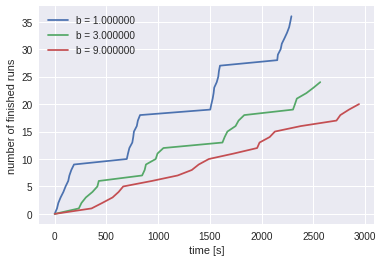

In [27]:
# START TODO ##################

hpvis.finished_runs_over_time(all_runs)


Evaluating configurations on lower budgets doesn't make sense - even if they are faster - if the performance ranking isn't consistent from low to high budget. This means, that the loss rankings for configurations should correlate. In simplified terms: The best configuration after one epoch should also be the best after nine epochs, the second best should stay the second best and so on.

**Task:** Plot correlations of rankings across budgets. Are the correlations high enough?

**Answer:**  Yes. There is a high correlation as we can understand from p values. The P values are less than or around 0.05, so the correlation is siginificant. Thus, the loss rankings are correlated between the confiigurations with budgets 9, 3 and 1. 

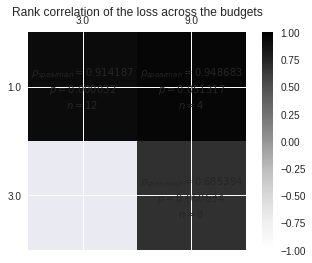

(<matplotlib.figure.Figure at 0x7f934dd61fd0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f934de18cc0>)

In [28]:
# START TODO ##################
hpvis.correlation_across_budgets(result,show=True)

We usually assume, that training on a higher budget (number of epochs) and sampling more configurations can lead to better results. Let's check this.

**Task:** Plot the losses over time. Do our assumptions hold true? Why?

**Answer:**  For our case, high budget (orange dots) shows the best performance in the overall system. However, for some samples it shows very poor performance, so it also depends on different configuration variables as well. Additionally, sampling more will lead to the optimal solution in theory because of the law of large numbers; however in practice, since the system is stochastic, we can find the best solution even in the first iterations. We can also see it in our example, as our model performs best for the earlier configurations. So essentially it can said that sampling more increases the change of finding better solutions, but it doesn't guarantee it.

(<matplotlib.figure.Figure at 0x7f934870e518>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f934874b6d8>)

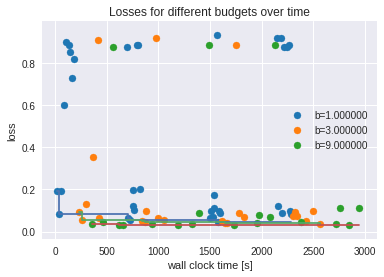

In [29]:
# START TODO ##################
hpvis.losses_over_time(all_runs)

Remember that BOHB uses a model after some time to improve the configuation sampling. We can check, if the BO-sampled configurations work better than the random-sampled.

**Task:** Plot loss histograms for all budgets only with BO-sampled and only with random-sampled configurations (6 histograms). Is the BO-sampling useful?

**Answer:** Yes. As we can see from the histogram, the values are differentiated more, i.e. the models with high performance and low performance have larger difference in frequency. So it produces more meaningful results.

(<matplotlib.figure.Figure at 0x7f93487e3278>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f933e854518>,
       dtype=object))

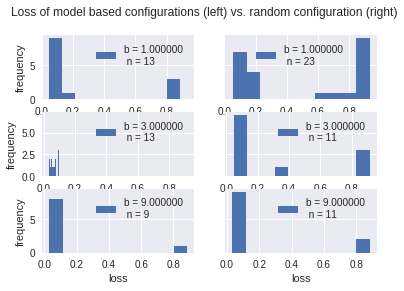

In [30]:
# START TODO ##################
hpvis.performance_histogram_model_vs_random(all_runs, id2conf)


### Your Feedback on Exercise 6.2

A very informative exercise to learn BOHB, glad that I did it. It took 4 - 6 hours to do it, such a short time to learn such a powerful toolbox, hopefully the next exercises will be also like that.